# Instalando Pacotes

In [1]:
!pip install unidecode
!pip install seaborn
!pip install stepwise-regression
!pip install mlxtend

# Importando Bibliotecas

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor # Árvore de Decisão
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.api as sm # Biblioteca para análises estatísticas
# from stepwise_regression import stepwise
from mlxtend.feature_selection import SequentialFeatureSelector
from statsmodels.stats.outliers_influence import variance_inflation_factor # para cálculo do VIF
from scipy import stats
from scipy.stats import boxcox
from scipy.stats import zscore
from datetime import datetime # Biblioteca para modelagem com datas
from functools import reduce, partial

# 1. Importanto dos Dados

## 1.1. Coleta de dados e Criando Dataframes

In [3]:
start = '01/01/2023'
end = '31/12/2023'

##### Coleta de dados do Banco Central:
urls = ['url_ipca_alim', 'url_ipca_hab', 'url_ipca_aresid', 'url_ipca_vest', 'url_ipca_transp', 'url_ipca_com', 'url_ipca_saude', 'url_ipca_desppess', 'url_ipca_educ',
        'url_ibc_br',
        'url_pnadc',
        'url_icc_25359', 'url_icc_27647', 'url_icc_25356', 'url_icc_27671', 'url_icc_27672', 'url_icc_27673', 'url_icc_27674','url_icc_27675', 'url_icc_27676', 'url_icc_27677', 'url_icc_27678', 'url_icc_27679', 'url_icc_27680', 'url_icc_27681', 'url_icc_27682','url_icc_27683', 'url_icc_27684','url_icc_27685','url_icc_27686','url_icc_27687',
        'url_crf_jd_sas',
        'url_endiv_serv']

code_url = [1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 24363, 24369, 25359, 27647, 25356, 27671, 27672, 27673, 27674, 27675, 27676, 27677, 27678, 27679, 27680, 27681, 27682, 27683, 27684, 27685, 27686, 27687, 29264, 29037]

def create_dataframe_url(nome):
    general_links = []
    for input_code in code_url:
       links= f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{input_code}/dados?formato=json&dataInicial={start}&dataFinal={end}'
       general_links.append(links)
    return general_links

for name_url in urls:
    names = create_dataframe_url(name_url)
    names

df_name_list = ['df_ipca_alim', 'df_ipca_hab', 'df_ipca_aresid', 'df_ipca_vest', 'df_ipca_transp', 'df_ipca_com', 'df_ipca_saude', 'df_ipca_desppess',
                'df_ipca_educ', 'df_ibc_br', 'df_pnadc', 'df_icc_25359', 'df_icc_27647', 'df_icc_25356', 'df_icc_27671', 'df_icc_27672', 'df_icc_27673', 
                'df_icc_27674','df_icc_27675', 'df_icc_27676', 'df_icc_27677', 'df_icc_27678', 'df_icc_27679', 'df_icc_27680', 'df_icc_27681', 
                'df_icc_27682','df_icc_27683', 'df_icc_27684','df_icc_27685','df_icc_27686','df_icc_27687', 'df_crf_jd_sas', 'df_endiv_serv']

def create_dataframe_json(url, df_name):
    base_for_dtaframes = pd.read_json(url)
    globals()[df_name] = base_for_dtaframes

for url, df_name in zip(names, df_name_list):
    create_dataframe_json(url, df_name)

##### Coleta de dados da Fenabrave
fenabrave = pd.read_excel('Fenabrave2023.xlsx')
df_fenabrave = pd.DataFrame(fenabrave)

### 1.1.1. Box-Plot dos dados da Fenabrave:
Há uma necessidade de avaliar mais o comportamento dos dados da Fenabrave, pois algumas eventos podem acontecer principamente na coleta dos dados, como será a explicado e ajustado no decorrer da análise.

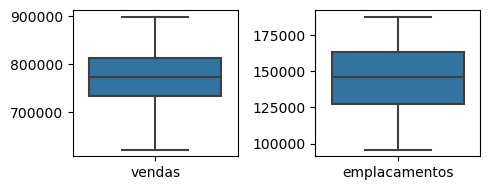

Analisando os dados foi verificado que não há outliers em seus valores brutos.


In [4]:
fig, axs = plt.subplots(1, 2, figsize=(5, 2))
sns.boxplot(data=df_fenabrave[['vendas']], ax=axs[0])
sns.boxplot(data=df_fenabrave[['emplacamentos']], ax=axs[1])
fig.tight_layout()
plt.show()
print('Analisando os dados foi verificado que não há outliers em seus valores brutos.')

# 2.  Modelagem de dados

## 2.1. Tratando os Dataframes

In [5]:
# Estimando dezembro usando média móvel até a divulgação dos dados oficiais:
df_crf_jd_sas['valor']  = pd.to_numeric(df_crf_jd_sas['valor'])
df_endiv_serv['valor']  = pd.to_numeric(df_endiv_serv['valor'])
dezembro_estimado_df_crf_jd_sas = df_crf_jd_sas['valor'].rolling(window=3, min_periods=1).mean().iloc[-1]
dezembro_estimado_df_endiv_serv = df_endiv_serv['valor'].rolling(window=3, min_periods=1).mean().iloc[-1]

df_crf_jd_sas.loc[len(df_crf_jd_sas)-1] = ['01/12/2023', dezembro_estimado_df_crf_jd_sas]
df_endiv_serv.loc[len(df_endiv_serv)-1] = ['01/12/2023', dezembro_estimado_df_endiv_serv]

#######################################################################################################################################

df_name_list = [df_ipca_alim, df_ipca_hab, df_ipca_aresid, df_ipca_vest, df_ipca_transp, df_ipca_com, df_ipca_saude, df_ipca_desppess, df_ipca_educ, 
                df_ibc_br, df_pnadc, df_icc_25359, df_icc_27647, df_icc_25356, df_icc_27671, df_icc_27672, df_icc_27673, df_icc_27674,df_icc_27675, 
                df_icc_27676, df_icc_27677, df_icc_27678, df_icc_27679, df_icc_27680, df_icc_27681, df_icc_27682,df_icc_27683, df_icc_27684,
                df_icc_27685,df_icc_27686,df_icc_27687, df_crf_jd_sas, df_endiv_serv
                ]

cols_valor_list = ['ipca_alim', 'ipca_hab', 'ipca_aresid', 'ipca_vest', 'ipca_transp', 'ipca_com', 'ipca_saude', 'ipca_desppess', 'ipca_educ',
                     'ibc_br', 'pnadc', 'icc_25359', 'icc_27647', 'icc_25356', 'icc_27671', 'icc_27672','icc_27673', 'icc_27674','icc_27675', 
                     'icc_27676', 'icc_27677', 'icc_27678', 'icc_27679', 'icc_27680', 'icc_27681', 'icc_27682','icc_27683', 'icc_27684',
                     'icc_27685','icc_27686','icc_27687', 'crf_jd_sas', 'endiv_serv'
                     ]

def format_date(dataframes_var, cols_valor_1):
    dataframes_var['data'] = pd.to_datetime(dataframes_var['data'], format='%d/%m/%Y')
    dataframes_var['valor']  = pd.to_numeric(dataframes_var['valor']).astype(float)
    dataframes_var.rename(columns={'valor': cols_valor_1}, inplace=True) 
    return dataframes_var

for dataframes_var, cols_valor_1 in zip(df_name_list, cols_valor_list):
    dataframes_var = format_date(dataframes_var, cols_valor_1)

df_fenabrave['data'] = pd.to_datetime(df_fenabrave['data'], format='%d/%m/%Y')
df_fenabrave['vendas'] = df_fenabrave['vendas'].astype(int)
df_fenabrave['qtd_semi_usad'] = df_fenabrave['vendas'].pct_change()*100
df_fenabrave['qtd_empl'] = df_fenabrave['emplacamentos'].pct_change()*100
df_fenabrave = df_fenabrave.drop(['vendas','emplacamentos'], axis=1)
df_fenabrave = df_fenabrave.drop(0).reset_index(drop=True)

### 2.1.1. Boxplot 2: Variações de Venda e Emplacamentos:

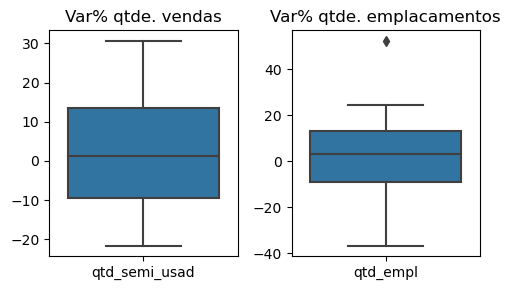


O outlier de 52,57% (ref. a mar/2023) na variável "quantidade de emplacamentos" deve-se ao fato que no período da apuração 
(fev/2023) algumas montadoras deram férias coletivas para seus funcionários atrelados ao setor de produção, influenciada 
pelas paralisações de fábricas automotivas brasileiras, baixa demanda por novos carros automotivos entre outros fatores, 
por isso a "base de comparação foi mais fraca" nesse período, segundo O presidente da Fenabrave, José Andreta Júnior. Nesse 
caso havendo a necessidade de tratar esse outlier com a média dos últimos 3 meses. 

Fonte:"https://economia.uol.com.br/noticias/reuters/2023/04/04/vendas-de-veiculos-novos-disparam-em-marco-sobre-base-de-comparacao-fraca-diz-fenabrave.htm#:~:text=O%20presidente%20da%20Fenabrave%2C%20Jos%C3%A9%20Andreta%20Jr.%2C%20afirmou,6%22.%20Esses%20padr%C3%B5es%20regulamentam%20a%20emiss%C3%A3o%20de%20poluentes." 


In [6]:
fig, axs = plt.subplots(1, 2, figsize=(5, 3))
sns.boxplot(data=df_fenabrave[['qtd_semi_usad']], ax=axs[0])
axs[0].set_title('Var% qtde. vendas')
sns.boxplot(data=df_fenabrave[['qtd_empl']], ax=axs[1])
axs[1].set_title('Var% qtde. emplacamentos')
fig.tight_layout()
plt.show()
print('\nO outlier de 52,57% (ref. a mar/2023) na variável "quantidade de emplacamentos" deve-se ao fato que no período da apuração \n(fev/2023) algumas montadoras deram férias coletivas para seus funcionários atrelados ao setor de produção, influenciada \npelas paralisações de fábricas automotivas brasileiras, baixa demanda por novos carros automotivos entre outros fatores, \npor isso a "base de comparação foi mais fraca" nesse período, segundo O presidente da Fenabrave, José Andreta Júnior. Nesse \ncaso havendo a necessidade de tratar esse outlier com a média dos últimos 3 meses. \n\nFonte:"https://economia.uol.com.br/noticias/reuters/2023/04/04/vendas-de-veiculos-novos-disparam-em-marco-sobre-base-de-comparacao-fraca-diz-fenabrave.htm#:~:text=O%20presidente%20da%20Fenabrave%2C%20Jos%C3%A9%20Andreta%20Jr.%2C%20afirmou,6%22.%20Esses%20padr%C3%B5es%20regulamentam%20a%20emiss%C3%A3o%20de%20poluentes." ')

#### 2.1.1.1 Tratando o outlier da coluna de Variação da Quantidade de Emplacamentos:

In [7]:
df_fenabrave = pd.DataFrame(fenabrave)
index_2 = 2
index_3 = 3
index_4 = 4
media_valores_2_4 = (df_fenabrave.at[index_2, 'emplacamentos'] + df_fenabrave.at[index_4, 'emplacamentos']) / 2
df_fenabrave.at[index_3, 'emplacamentos'] = media_valores_2_4

df_fenabrave['data'] = pd.to_datetime(df_fenabrave['data'], format='%d/%m/%Y')
df_fenabrave['vendas'] = df_fenabrave['vendas'].astype(int)
df_fenabrave['qtd_semi_usad'] = df_fenabrave['vendas'].pct_change()*100
df_fenabrave['qtd_empl'] = df_fenabrave['emplacamentos'].pct_change()*100
df_fenabrave = df_fenabrave.drop(['vendas','emplacamentos'], axis=1)
df_fenabrave = df_fenabrave.drop(0).reset_index(drop=True)

### 2.1.2. Boxplot 3: após tratar o outlier na variação da quantidade de emplacamentos

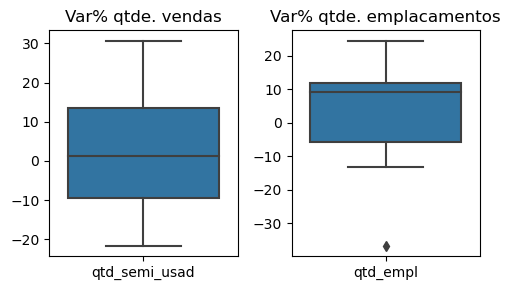


 Após o ajuste foi verificado o outlier -36,8% (ref. a jan/2023) na variável "quantidade de emplacamentos" não deve ser tratado 
 pois é um retrato do que ocorreu na economia com a alta dos preços dos automóveis novos.


In [8]:
fig, axs = plt.subplots(1, 2, figsize=(5, 3))
sns.boxplot(data=df_fenabrave[['qtd_semi_usad']], ax=axs[0])
axs[0].set_title('Var% qtde. vendas')
sns.boxplot(data=df_fenabrave[['qtd_empl']], ax=axs[1])
axs[1].set_title('Var% qtde. emplacamentos')
fig.tight_layout()
plt.show()
print('\n Após o ajuste foi verificado o outlier -36,8% (ref. a jan/2023) na variável "quantidade de emplacamentos" não deve ser tratado \n pois é um retrato do que ocorreu na economia com a alta dos preços dos automóveis novos.')

## 2.2. Concatenando os as variáveis em um único dataframe: base

In [9]:
df_variables = [df_fenabrave,df_ipca_alim, df_ipca_hab, df_ipca_aresid, df_ipca_vest, df_ipca_transp, df_ipca_com, df_ipca_saude, df_ipca_desppess, 
                df_ipca_educ, df_ibc_br, df_pnadc, df_icc_25359, df_icc_27647, df_icc_25356, df_icc_27671, df_icc_27672, df_icc_27673, df_icc_27674,
                df_icc_27675, df_icc_27676, df_icc_27677, df_icc_27678, df_icc_27679, df_icc_27680, df_icc_27681, df_icc_27682,df_icc_27683, df_icc_27684,
                df_icc_27685,df_icc_27686,df_icc_27687, df_crf_jd_sas, df_endiv_serv
                ]
merge_func = partial(pd.merge, on='data', how='left', sort=False)
base = reduce(merge_func, df_variables)
base['Month'] = base['data'].dt.month

base = base[['Month', 'qtd_semi_usad', 'qtd_empl',
             'ipca_alim', 'ipca_hab', 'ipca_aresid', 'ipca_vest', 'ipca_transp', 'ipca_com', 'ipca_saude', 'ipca_desppess', 'ipca_educ',
             'ibc_br', 'pnadc', 'icc_25359', 'icc_27647', 'icc_25356', 'icc_27671', 'icc_27672','icc_27673', 'icc_27674','icc_27675', 
             'icc_27676', 'icc_27677', 'icc_27678', 'icc_27679', 'icc_27680', 'icc_27681', 'icc_27682','icc_27683', 'icc_27684',
             'icc_27685','icc_27686','icc_27687', 'crf_jd_sas', 'endiv_serv'
             ]]

In [10]:
base

,Month,qtd_semi_usad,qtd_empl,ipca_alim,ipca_hab,ipca_aresid,ipca_vest,ipca_transp,ipca_com,ipca_saude,...,icc_27680,icc_27681,icc_27682,icc_27683,icc_27684,icc_27685,icc_27686,icc_27687,crf_jd_sas,endiv_serv
0,1,-21.638870,-36.728615,0.59,0.33,0.70,-0.27,0.55,2.09,0.16,...,25.14,71.62,18.76,13.62,415.69,171.77,46.47,45.29,9.27,48.88
1,2,-7.737803,-7.762438,0.16,0.82,0.11,-0.24,0.37,0.98,1.26,...,25.37,72.04,18.73,13.63,420.42,174.09,50.04,47.03,10.21,48.71
2,3,30.692591,11.647131,0.05,0.57,-0.27,0.31,2.11,0.50,0.82,...,25.62,72.49,18.73,13.72,433.33,177.22,46.97,47.85,10.12,48.60
3,4,-20.550229,10.432092,0.71,0.48,0.17,0.79,0.56,0.08,1.49,...,25.81,72.82,18.74,13.83,447.33,179.80,49.32,48.66,9.92,48.70
4,5,22.674121,7.919443,0.16,0.67,-0.23,0.47,-0.57,0.21,0.93,...,26.00,73.18,18.61,13.93,453.97,179.87,48.24,48.62,9.34,49.02
5,6,-7.312341,11.401610,-0.66,0.69,-0.42,0.35,-0.41,-0.14,0.11,...,26.10,73.80,21.78,14.36,435.84,181.14,48.35,47.80,9.32,48.60
6,7,5.325720,24.451298,-0.46,-1.01,0.04,-0.24,1.50,0.00,0.26,...,26.16,74.32,21.99,14.46,441.33,182.63,47.29,48.08,9.50,48.22
7,8,12.291062,-13.162689,-0.85,1.11,-0.04,0.54,0.34,-0.09,0.58,...,26.21,74.64,22.20,14.51,445.51,182.82,47.00,47.58,9.80,48.44
8,9,-14.036537,-5.079555,-0.71,0.47,-0.58,0.38,1.40,-0.11,0.04,...,26.24,74.93,22.27,14.91,441.11,183.40,45.96,47.39,9.62,48.22
9,10,4.245223,11.979517,0.31,0.02,0.46,0.45,0.35,-0.19,0.32,...,26.28,75.09,22.59,15.03,444.92,184.61,43.23,47.53,9.01,48.23


# 3. Analisando os Dados

## 3.1. Método Stepwise: para seleção das variáveis

In [26]:
variables_x = base.iloc[:,2:]
dependent_y = base['qtd_semi_usad']

def stepwise(X, y,
                       initial_list=[],
                       threshold_in=0.05,
                       threshold_out=0.05,
                       verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Adicionado variável: {:30}  |  P-valor: {:.6f}'.format(best_feature, best_pval))

        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Removida variável: {:30}  |  P-valor: {:.6f}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

var_stepwise = stepwise(variables_x, dependent_y)

variables_x_sw = pd.DataFrame()
for feature in var_stepwise:
    variables_x_sw[feature] = variables_x[feature]

var_stepwise

Adicionado variável: icc_27672                       |  P-valor: 0.022419
Adicionado variável: ibc_br                          |  P-valor: 0.012150


['icc_27672', 'ibc_br']

### 3.1.1. Estatística descritiva das variáveis escolhidas:

In [29]:
base[list(var_stepwise)].describe()

,icc_27672,ibc_br
count,12.000000,12.000000
mean,132.057500,146.351667
std,1.882108,5.580889
min,128.250000,135.830000
25%,131.012500,144.287500
50%,131.965000,145.380000
75%,133.610000,149.057500
max,134.660000,158.230000


### 3.1.2. Box-plot com as variáveis escolhidas através de aplicar stepwise:

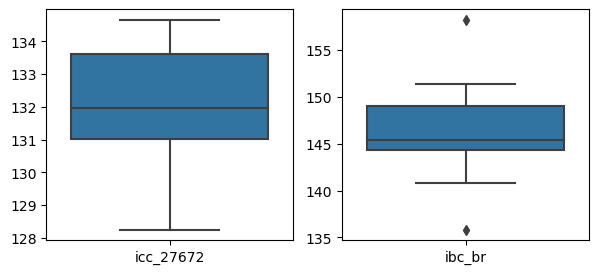

O Índice de Atividade Econômica do Banco Central (IBC-Br) apresenta existência de outliers. Contudo, esses valores 
são importantes para o modelo, pois esse índice representa o comportamento da atividade econômica brasileira. 
Esses dados são divulgados pelo Banco Central do Brasil e é considerado no mercado como uma prevía do Produto Interno Bruto (PIB) 
que é divulgado pelo IBGE.


In [12]:
x_sw = base[list(var_stepwise)]
y_sw = base['qtd_semi_usad']

col_groups = [list(range(i, i + 1)) for i in range(0, len(var_stepwise))]
fig, axs = plt.subplots(1, len(var_stepwise), figsize=(7, 3))
fig.subplots_adjust(hspace=0.4)
for i, ax in enumerate(axs.flatten()):
    if i < len(col_groups):
        sns.boxplot(data=x_sw.iloc[:, col_groups[i]], ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

plt.show()
print('O Índice de Atividade Econômica do Banco Central (IBC-Br) apresenta existência de outliers. Contudo, esses valores \nsão importantes para o modelo, pois esse índice representa o comportamento da atividade econômica brasileira. \nEsses dados são divulgados pelo Banco Central do Brasil e é considerado no mercado como uma prevía do Produto Interno Bruto (PIB) \nque é divulgado pelo IBGE.')

## 3.2. Verificando a dispersão entre as variáveis escolhidas

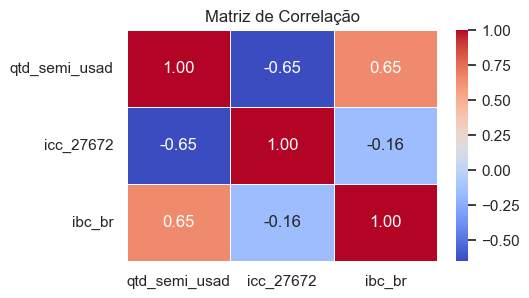

In [13]:
base_variable = ['qtd_semi_usad'] + list(x_sw.columns)
cols_yx = pd.concat([y_sw,x_sw], axis=1)
cols = cols_yx[base_variable].columns.tolist()
correlation_matrix = cols_yx[cols].corr()
sns.set(style="white")
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

## 3.3. Resultado: Modelo OLS

In [24]:
model_ols_stepwise = sm.OLS(y_sw, sm.add_constant(x_sw)).fit()
print(model_ols_stepwise.summary())
print('\n⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂')
print(f'⁂ Usando o método stepwise para escolha das variáreis: o modelo explica {round(model_ols_stepwise.rsquared*100,2)}% do comportamento da variação da quantidade de seminovos vendidos.⁂')
print('⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂\n')

                            OLS Regression Results                            
Dep. Variable:          qtd_semi_usad   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     11.73
Date:                Mon, 04 Mar 2024   Prob (F-statistic):            0.00311
Time:                        13:34:25   Log-Likelihood:                -42.713
No. Observations:                  12   AIC:                             91.43
Df Residuals:                       9   BIC:                             92.88
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        417.8583    236.211      1.769      0.1

c:\Users\Usuário\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### 3.3.1. V.I.F. - Testando a Multicolinearidade das variáveis no modelo OLS

In [25]:
vif_data = pd.DataFrame()
# x_sw_constat = sm.add_constant(x_sw)
x_sw_constat = x_sw
vif_data["Variável"] = x_sw_constat.columns
vif_data["VIF"] = [variance_inflation_factor(x_sw_constat.values, i) for i in range(x_sw_constat.shape[1])]
for i in range(len(vif_data["VIF"])):
    if vif_data["VIF"].iloc[i] < 5:
        print(f'Não há evidência de multicolinearidade {vif_data["Variável"].iloc[i]} | VIF: {vif_data["VIF"].iloc[i]}')
    else:
        print(f'Há evidência(s) de multicolinearidade {vif_data["Variável"].iloc[i]} | VIF: {vif_data["VIF"].iloc[i]}')

Há evidência(s) de multicolinearidade icc_27672 | VIF: 596.3748396260747
Há evidência(s) de multicolinearidade ibc_br | VIF: 596.3748396260747


### 3.3.2. Verificando a normalidade dos resíduos no modelo OLS: Shapiro Wilk

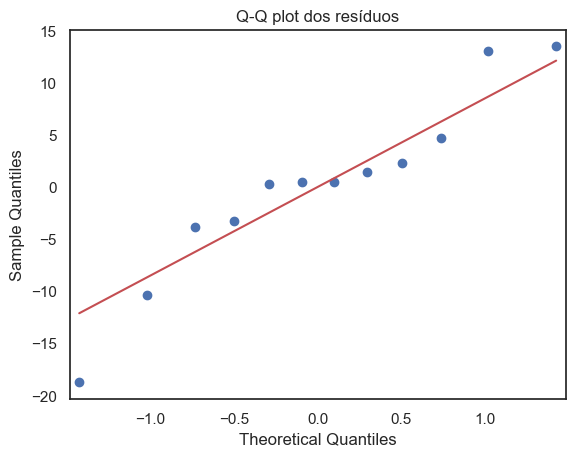

Teste de Shapiro-Wilk - Estatística: 0.9321399927139282, P-valor: 0.40334823727607727
Os resíduos parecem seguir uma distribuição normal (não rejeitamos a hipótese nula)


In [16]:
residuos = model_ols_stepwise.resid
stat, p_valor = stats.shapiro(residuos)
sm.qqplot(residuos, line='s')
plt.title('Q-Q plot dos resíduos')
plt.show()

print(f'Teste de Shapiro-Wilk - Estatística: {stat}, P-valor: {p_valor}')

coef_confinça= 0.05
if p_valor > coef_confinça:
    print("Os resíduos parecem seguir uma distribuição normal (não rejeitamos a hipótese nula)")
else:
    print("Os resíduos não seguem uma distribuição normal (rejeitamos a hipótese nula)")

### 3.3.4. Gráficos do modelo OLS

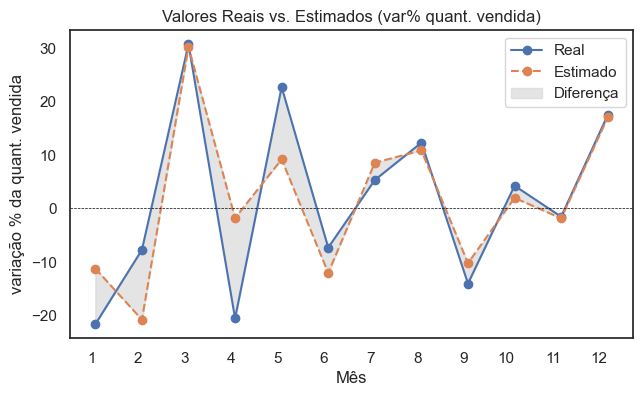

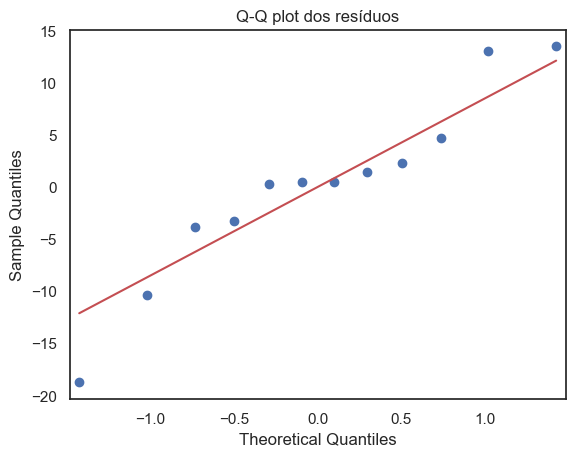

⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂ 
Resumo:
Apesar do modelo apresentado explicar estatisticamente o comportamento da variação da quantidade vendida e com o VIF 
não apresentando incidência de multicolinearidade o modelo demonstra obter resultados muito próximos da realidade 
quando usado com os dados reais, podendo ocasinar em overfit. 
⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂


In [20]:
y_pred = model_ols_stepwise.predict()
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(base['Month'], y_sw, label='Real', marker='o')
plt.plot(base['Month'], y_pred, label='Estimado', linestyle='dashed', marker='o')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.fill_between(base['Month'], y_sw, y_pred, color='lightgrey', alpha=0.6, label='Diferença')
plt.title('Valores Reais vs. Estimados (var% quant. vendida)')
plt.xlabel('Mês')
plt.ylabel('variação % da quant. vendida')
plt.xticks(base['Month'].unique(), rotation=0, ha='right')  # Apenas exibir meses únicos no eixo x
plt.legend()
# ##########################
residuos = model_ols_stepwise.resid
stat, p_valor = stats.shapiro(residuos)
sm.qqplot(residuos, line='s')
plt.title('Q-Q plot dos resíduos')
plt.show()
###########################
print('⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂ \nResumo:\nApesar do modelo apresentado explicar estatisticamente o comportamento da variação da quantidade vendida e com o VIF \nnão apresentando incidência de multicolinearidade o modelo demonstra obter resultados muito próximos da realidade \nquando usado com os dados reais, podendo ocasinar em overfit. \n⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂')

In [18]:
#⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂⁂#